# Regression

## Linear Regression

US-pumpkins.csv which includes 1757 lines of data about the market for pumpkins, sorted into groupings by city. This is raw data extracted from the Specialty Crops Terminal Markets Standard Reports distributed by the United States Department of Agriculture.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score


pumpkins = pd.read_csv('../Regression/US-pumpkins.csv')
pumpkins.head()

,City Name,Type,Package,Variety,Sub Variety,Grade,Date,Low Price,High Price,Mostly Low,...,Unit of Sale,Quality,Condition,Appearance,Storage,Crop,Repack,Trans Mode,Unnamed: 24,Unnamed: 25
0,BALTIMORE,NaN,24 inch bins,NaN,NaN,NaN,4/29/17,270.0,280.0,270.0,...,NaN,NaN,NaN,NaN,NaN,NaN,E,NaN,NaN,NaN
1,BALTIMORE,NaN,24 inch bins,NaN,NaN,NaN,5/6/17,270.0,280.0,270.0,...,NaN,NaN,NaN,NaN,NaN,NaN,E,NaN,NaN,NaN
2,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,9/24/16,160.0,160.0,160.0,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN
3,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,9/24/16,160.0,160.0,160.0,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN
4,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,11/5/16,90.0,100.0,90.0,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN


In [2]:
pumpkins = pumpkins[pumpkins['Package'].str.contains('bushel', case=True, regex=True)]

In [3]:
#Check if there is missing data in the current dataframe:
pumpkins.isnull().sum()

City Name            0
Type               406
Package              0
Variety              0
Sub Variety        167
Grade              415
Date                 0
Low Price            0
High Price           0
Mostly Low          24
Mostly High         24
Origin               0
Origin District    396
Item Size          114
Color              145
Environment        415
Unit of Sale       404
Quality            415
Condition          415
Appearance         415
Storage            415
Crop               415
Repack               0
Trans Mode         415
Unnamed: 24        415
Unnamed: 25        391
dtype: int64

In [4]:
###Drop columns, using drop().

new_columns = ['City Name','Package', 'Month', 'Low Price', 'High Price', 'Date','Variety']
pumpkins = pumpkins.drop([c for c in pumpkins.columns if c not in new_columns], axis=1)

In [5]:
#Determine average price of pumpkin

price = (pumpkins['Low Price'] + pumpkins['High Price']) / 2

month = pd.DatetimeIndex(pumpkins['Date']).month

In [6]:
#Converted data into a fresh Pandas dataframe and normalize data

new_pumpkins = pd.DataFrame({'Month': month,'Variety': pumpkins['Variety'],'City':pumpkins['City Name'],'Package': pumpkins['Package'], 'Low Price': pumpkins['Low Price'],'High Price': pumpkins['High Price'], 'Price': price})

new_pumpkins.loc[new_pumpkins['Package'].str.contains('1 1/9'), 'Price'] = price/(1 + 1/9)

new_pumpkins.loc[new_pumpkins['Package'].str.contains('1/2'), 'Price'] = price/(1/2)

new_pumpkins


,Month,Variety,City,Package,Low Price,High Price,Price
70,9,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,15.00,15.0,13.50
71,9,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,18.00,18.0,16.20
72,10,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,18.00,18.0,16.20
73,10,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,17.00,17.0,15.30
74,10,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,15.00,15.0,13.50
...,...,...,...,...,...,...,...
1738,9,MINIATURE,ST. LOUIS,1/2 bushel cartons,15.00,15.0,30.00
1739,9,MINIATURE,ST. LOUIS,1/2 bushel cartons,13.75,15.0,28.75
1740,9,MINIATURE,ST. LOUIS,1/2 bushel cartons,10.75,15.0,25.75
1741,9,MINIATURE,ST. LOUIS,1/2 bushel cartons,12.00,12.0,24.00


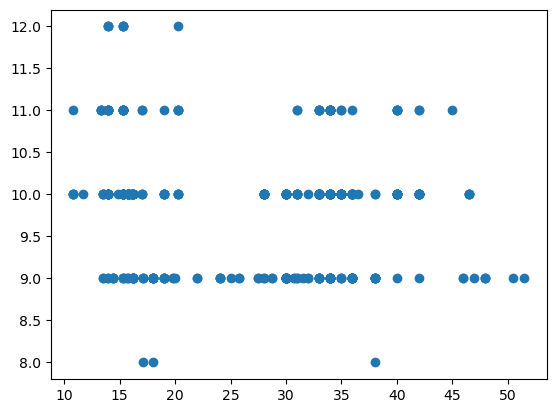

In [7]:
#Visualization

price = new_pumpkins.Price
month = new_pumpkins.Month
plt.scatter(price, month)
plt.show()

Text(0, 0.5, 'Pumpkin Price')

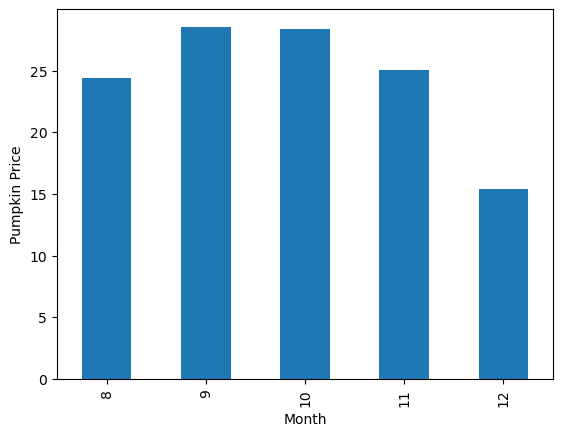

In [8]:
new_pumpkins.groupby(['Month'])['Price'].mean().plot(kind='bar')
plt.ylabel("Pumpkin Price")

The highest price for pumpkins occurs in September and October.

### Prepare data for regression

In [9]:
new_pumpkins.iloc[:, 0:-1] = new_pumpkins.iloc[:, 0:-1].apply(LabelEncoder().fit_transform)

In [10]:
print(new_pumpkins['City'].corr(new_pumpkins['Price']))

0.32382509936087445


In [11]:
print(new_pumpkins['Package'].corr(new_pumpkins['Price']))

0.6088482822590107


### Building a linear model

In [12]:
new_pumpkins.dropna(inplace=True)
new_pumpkins.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 415 entries, 70 to 1742
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Month       415 non-null    int64  
 1   Variety     415 non-null    int64  
 2   City        415 non-null    int64  
 3   Package     415 non-null    int64  
 4   Low Price   415 non-null    int64  
 5   High Price  415 non-null    int64  
 6   Price       415 non-null    float64
dtypes: float64(1), int64(6)
memory usage: 42.1 KB


In [13]:
new_columns = ['Package', 'Price']
lin_pumpkins = new_pumpkins.drop([c for c in new_pumpkins.columns if c not in new_columns], axis='columns')

lin_pumpkins

,Package,Price
70,0,13.50
71,0,16.20
72,0,16.20
73,0,15.30
74,0,13.50
...,...,...
1738,2,30.00
1739,2,28.75
1740,2,25.75
1741,2,24.00


In [14]:
X = lin_pumpkins.values[:, :1]
y = lin_pumpkins.values[:, 1:2]

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)

pred = lin_reg.predict(X_test)

accuracy_score = lin_reg.score(X_train,y_train)
print('Model Accuracy: ', accuracy_score)

Model Accuracy:  0.3348784132038001


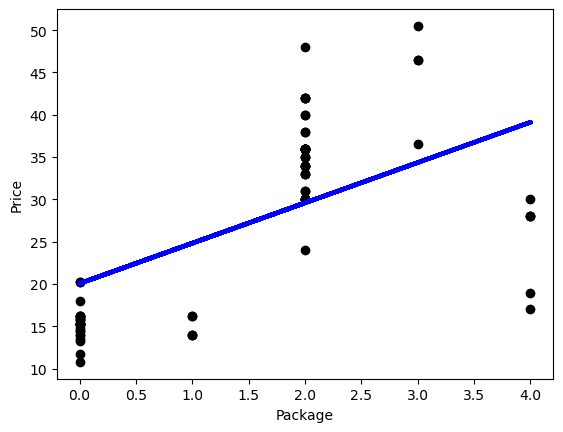

In [16]:
plt.scatter(X_test, y_test,  color='black')
plt.plot(X_test, pred, color='blue', linewidth=3)

plt.xlabel('Package')
plt.ylabel('Price')

plt.show()

In [17]:
lin_reg.predict( np.array([ [2.75] ]) )

array([[33.16833759]])

## Polynomial regression
Polynomial regression creates a curved line to better fit nonlinear data.

In [18]:
new_columns = ['Variety', 'Package', 'City', 'Month', 'Price']
poly_pumpkins = new_pumpkins.drop([c for c in new_pumpkins.columns if c not in new_columns], axis='columns')

poly_pumpkins

,Month,Variety,City,Package,Price
70,1,3,1,0,13.50
71,1,3,1,0,16.20
72,2,3,1,0,16.20
73,2,3,1,0,15.30
74,2,3,1,0,13.50
...,...,...,...,...,...
1738,1,1,9,2,30.00
1739,1,1,9,2,28.75
1740,1,1,9,2,25.75
1741,1,1,9,2,24.00


In [19]:
corr = poly_pumpkins.corr()
corr.style.background_gradient(cmap='coolwarm')

,Month,Variety,City,Package,Price
Month,1.000000,0.171330,-0.188728,-0.144847,-0.149129
Variety,0.171330,1.000000,-0.248441,-0.614855,-0.864428
City,-0.188728,-0.248441,1.000000,0.301604,0.323825
Package,-0.144847,-0.614855,0.301604,1.000000,0.608848
Price,-0.149129,-0.864428,0.323825,0.608848,1.000000


good correlation between Package and Price.

### Create a pipeline

In [20]:
X=poly_pumpkins.iloc[:,3:4].values
y=poly_pumpkins.iloc[:,4:5].values

In [21]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(PolynomialFeatures(4), LinearRegression())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

pipeline.fit(np.array(X_train), y_train)

y_pred=pipeline.predict(X_test)

### Create a sequence

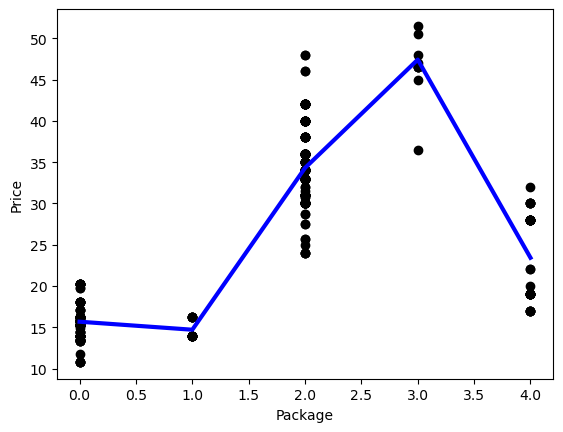

In [22]:
df = pd.DataFrame({'x': X_test[:,0], 'y': y_pred[:,0]})
df.sort_values(by='x',inplace = True)
points = pd.DataFrame(df).to_numpy()

plt.plot(points[:, 0], points[:, 1],color="blue", linewidth=3)
plt.xlabel('Package')
plt.ylabel('Price')
plt.scatter(X,y, color="black")
plt.show()

In [23]:
accuracy_score = pipeline.score(X_train,y_train)
print('Model Accuracy: ', accuracy_score)

Model Accuracy:  0.8558738910762582


## Logistic Regression
A prediction about a binary category ("orange or not orange"). 

In [24]:
pumpkins = pd.read_csv('../Regression/US-pumpkins.csv')

new_columns = ['Color','Origin','Item Size','Variety','City Name','Package']

new_pumpkins = pumpkins.drop([c for c in pumpkins.columns if c not in new_columns], axis=1)

new_pumpkins.dropna(inplace=True)

new_pumpkins = new_pumpkins.apply(LabelEncoder().fit_transform)

In [25]:
new_pumpkins

,City Name,Package,Variety,Origin,Item Size,Color
2,1,3,4,3,3,0
3,1,3,4,17,3,0
4,1,3,4,5,2,0
5,1,3,4,5,2,0
6,1,4,4,5,3,0
...,...,...,...,...,...,...
1694,12,3,5,4,6,1
1695,12,3,5,4,6,1
1696,12,3,5,4,6,1
1697,12,3,5,4,6,1


The next plot shows how the each variable relate with the others.

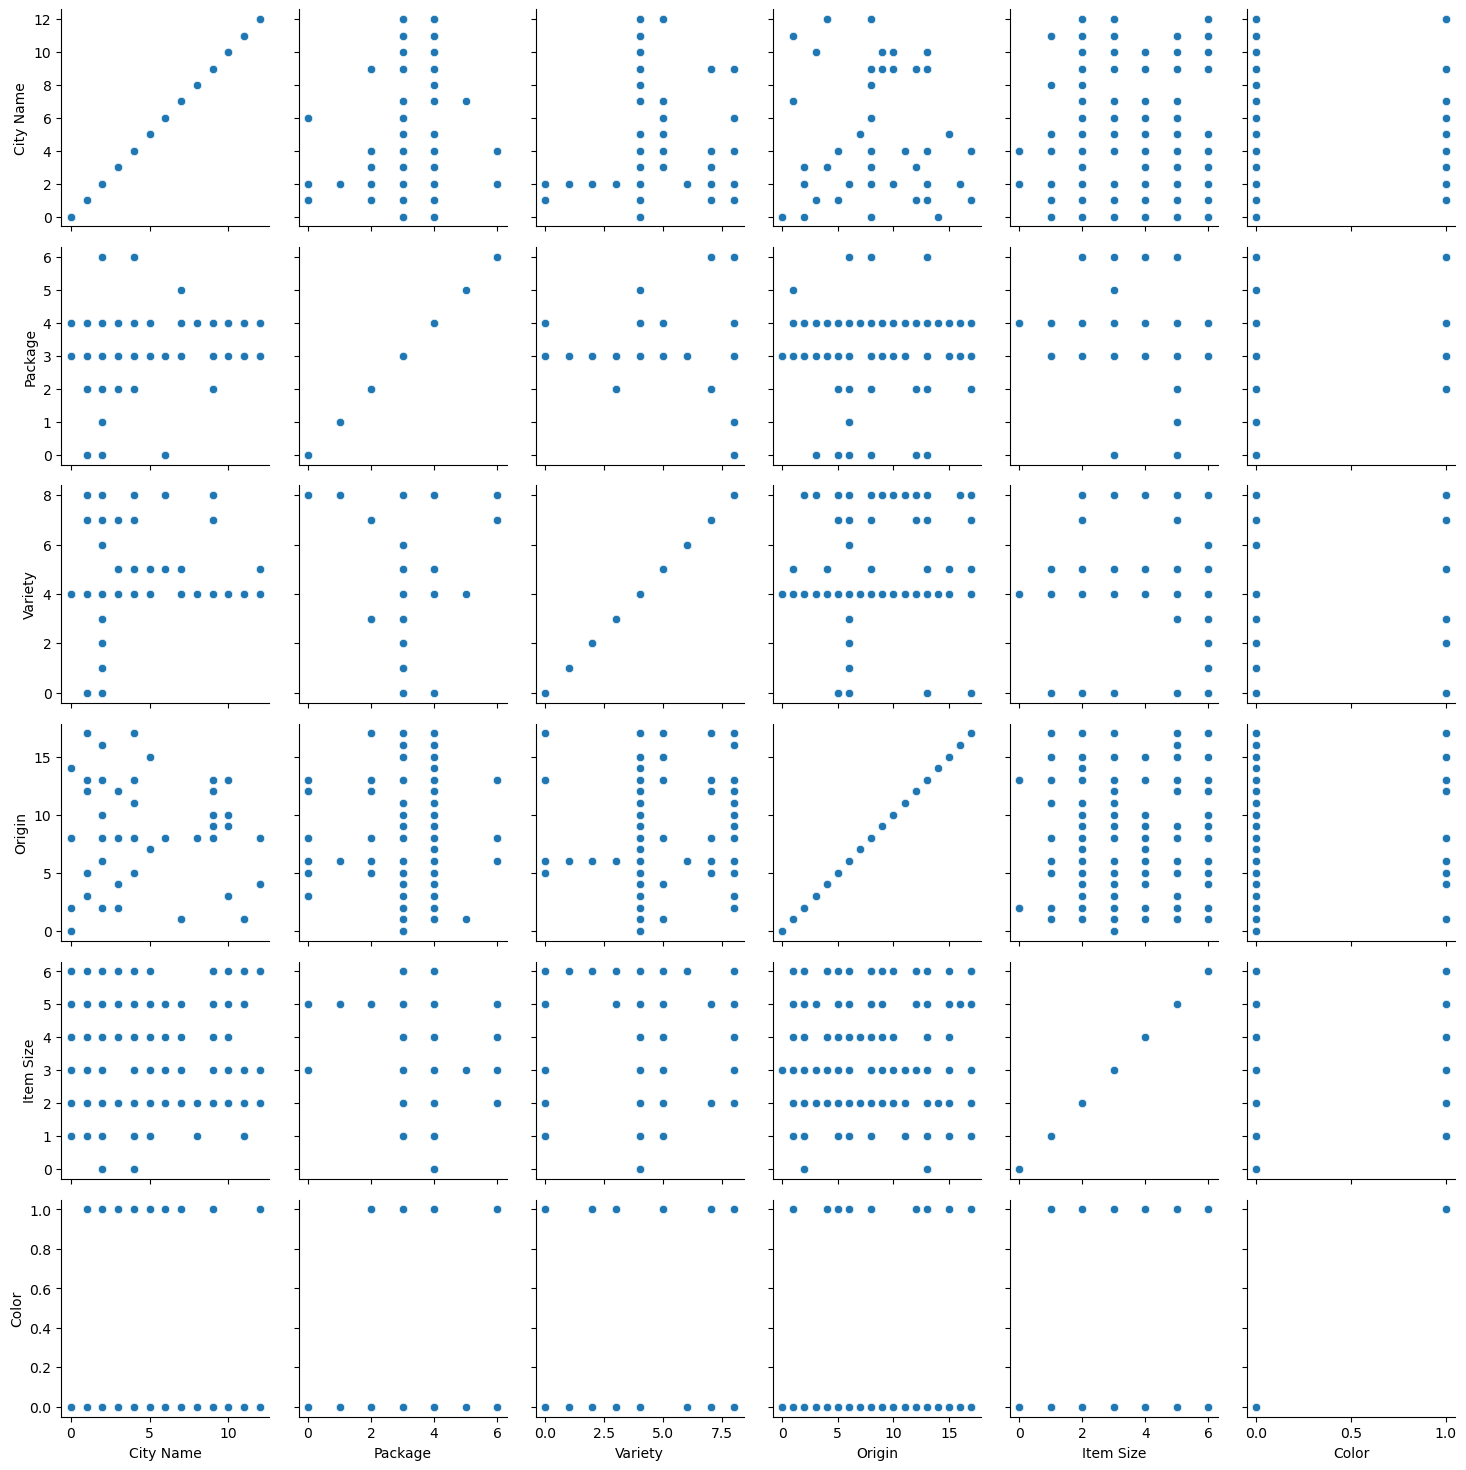

In [26]:
g = sns.PairGrid(new_pumpkins)
g.map(sns.scatterplot)

### Building a model to find these binary classification
1. Select the variables
2. Training model

In [27]:
Selected_features = ['Origin','Item Size','Variety','City Name','Package']

X = new_pumpkins[Selected_features]
y = new_pumpkins['Color']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [28]:
model = LogisticRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

print(classification_report(y_test, predictions))
print('Predicted labels: ', predictions)

              precision    recall  f1-score   support

           0       0.83      0.98      0.90       166
           1       0.00      0.00      0.00        33

    accuracy                           0.81       199
   macro avg       0.42      0.49      0.45       199
weighted avg       0.69      0.81      0.75       199

Predicted labels:  [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0]


#### Confusion Matrix

In [29]:
confusion_matrix(y_test, predictions)

array([[162,   4],
       [ 33,   0]])

#### ROC curve 
ROC curves are often used to get a view of the output of a classifier in terms of its true vs. false positives. 

<AxesSubplot:>

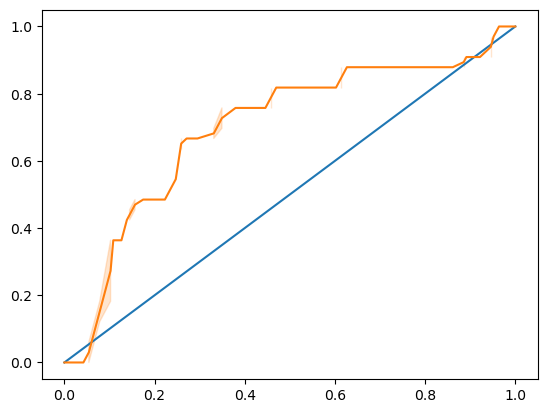

In [30]:
y_scores = model.predict_proba(X_test)
# calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test,y_scores[:,1])
sns.lineplot([0, 1], [0, 1])
sns.lineplot(fpr, tpr)

Using Scikit-learn's roc_auc_score API to compute the actual 'Area Under the Curve' (AUC).

In [31]:
auc = roc_auc_score(y_test,y_scores[:,1])
print(auc)

0.6976998904709748
